# PyTorch

```Tutorials:``` https://pytorch.org/tutorials/

In [ ]:
import numpy as np

import torch
import torchvision
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

### Pipeline
  - Data:
      - Load dataset
      - DataLoader
      - Visualize dataset samples
  - Design Model:
      - Model Architecture
      - Forward Pass
  - Define Loss Function
  - Define Optimizer
  - Train:
      - Forward Pass (compute activations and loss)
      - Backward Pass (compute gradients)
      - Update Weights

# Training and Evaluation Multi-Layer Perceptron (MLP)

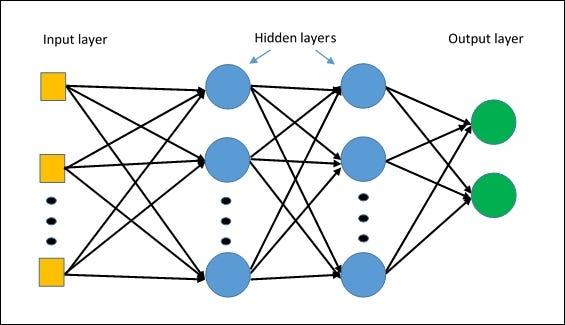

## The MNIST Dataset

Official webpage: http://yann.lecun.com/exdb/mnist/

The MNIST database contains 60,000 training images and 10,000 testing images. We can flatten this array into a vector of 28x28 = 784 numbers.

MNIST is a simple computer vision dataset. It consists of images of handwritten digits like these:

<img src="imgs/MNIST.png">

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1.

## Dataset and Transform

If we have some ``.csv`` file which represent data, we can easily create PyTorch object Dataset, which will represent "real" PyTorch dataset. That ``.csv`` data will be wrapped into PyTorch.

Additionaly, as attribute of ``Dataset`` object, we can have ``Transform`` object, that we can later use to apply on samples of dataset that we taking using indexing or using ``DataLoader`` (e.g. usually we want to convert NumPy arrays to PyTorch tensors).

We can also define our own ``Transform`` object, but I did not write that here (I used built-in transforms).

## Existing PyTorch datasets (MNIST)

https://pytorch.org/vision/stable/datasets.html

All datasets in PyTorch are classes themselves (instances of ``class Dataset``). If dataset wants to be a class, it needs to implement two functions:
 - __len__
 - __getitem__

In [ ]:
# MNIST dataset is instance of class Dataset
# Therefore it can be passed to DataLoader later for easier usage of data
# some famous datasets are available in torchvision.datasets
# e.g. MNIST, Fashion-MNIST, CIFAR10, COCO
# https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
print(type(train_dataset))
print(type(test_dataset))

### __len__

In [ ]:
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)

In [ ]:
print(n_imgs_train)
print(n_imgs_test)

### __getitem__

To access image and label for that image, use two sets of square brackets. First square brackets are used for specifying which sample you want from dataset (0..N), and second square brackets are used for specifying whether you want to load sample/image (0) or label for that sample/image (1).

With this we can iterate through our dataset. But this is not the best and most used way of iterating through dataset. Below is explained proper way of doing it.

In [ ]:
img_shape = train_dataset[0][0].shape
print(img_shape)

In [ ]:
label = test_dataset[0][1]
print(label)

## DataLoader

With our Dataset object we can iterate over the Dataset by sampling images and their corresponding targets. <br>
However, this is somewhat cumbersone and does not scale too well.<br>

In practice, we use Data Loaders, which provide an efficient way to iterate a Dataset object. 

 - https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [ ]:
BATCH_SIZE = 1024
SHUFFLE_TRAIN = True
SHUFFLE_TEST = False

In [ ]:
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

In [ ]:
eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [ ]:
eval_iter = iter(eval_loader)
imgs_eval, labels_eval = next(eval_iter)
print(f"{imgs_eval.shape = }")
print(f"{labels_eval.shape = }")

In [ ]:
print(len(imgs_eval))
print(len(labels_eval))

In [ ]:
# We can iterate over whole Dataset using DataLoader
num_epochs = 2
for epoch in range(num_epochs):
    print("Epoch: " + str(epoch))
    for i, (imgs_eval, labels_eval) in enumerate(eval_loader):
        print(f"Iterating batch #{i+1}, which has {len(labels_eval)} elements (images and its corresponding labels)")

## Dataset visualization

In [ ]:
N_IMGS = 4
fig, ax = plt.subplots(1, N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    #img = train_dataset[n][0].numpy().transpose(1,2,0)
    img = train_dataset[n][0].permute(1, 2, 0)
    label_idx = train_dataset[n][1]
    
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {label_idx}")
    ax[i].axis("off")
plt.show()

## 4.2 Fully Connected Network and Multi-Layer Perceptron

Let's now implement our first neural networks. We will implement fully connected network (or MLPs if they have over one layer) for classification.

<img src="imgs/MLP.png" width="20%"> <span style="width: 300px"></span> <img src="imgs/softmax.png" width="48%'">

In [ ]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation (ReLU)
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred

In [ ]:
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [ ]:
model = Model(input_dim=784, hidden_dim=128, output_dim=10)
print(model)

In [ ]:
count_model_params(model)

In [ ]:
imgs, labels = next(iter(eval_loader))      # sampling images
flattened_imgs = imgs.flatten(start_dim=1)  # reshaping to desired size (start_dim=1 because this is batch)
output = model(flattened_imgs)              # forward pass through model

print(f"Imgs shape:         {imgs.shape}")
print(f"Model input shape:  {flattened_imgs.shape}")
print(f"Model output shape: {output.shape}")

## 4.3 Training the Model

In [ ]:
input_dim = flattened_imgs.shape[1]
print(input_dim)

In [ ]:
NUM_EPOCHS = 10
LR = 3e-4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=input_dim, hidden_dim=128, output_dim=10)
model = model.to(device)

In [ ]:
# CrossEntropyLoss is used for Multi-Class classification. Target labels from dataset can be scalar (indicating class) 
# and output of model can be like list of 10 elements (for 10 classes), it will compute the loss 

# Another practical note, in Pytorch if one uses the nn.CrossEntropyLoss the input must be unnormalized raw value (aka logits)
# and the target must be class index instead of one hot encoded vectors.

In [ ]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
loss_list = []

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    
        # computing loss (loss is Tensor of 1 element, loss.item() is scalar)
        loss = criterion(preds, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backpropagation - computing gradients
        loss.backward()
    
        # updating parameters/weights
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

## 4.4 Evaluating Trained Model

In [ ]:
n_correct = 0

In [ ]:
# We don't need gradients for inference only, so we can disregard them, by putting the whole block of code
# into the torch.no_grad() section
with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
        
        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

In [ ]:
accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

## Saving and Loading Model Checkpoints

```Reference:``` https://pytorch.org/tutorials/beginner/saving_loading_models.html

### Saving Trained Model

```model.state_dict()``` contains all learned weights and biases, for all layers and all neurons in those layers

In [ ]:
if(not os.path.exists("models")):
    os.makedirs("models")

In [ ]:
savepath = f"models/checkpoint_epoch_{epoch}.pth"

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, savepath)

### Loading Trained Model

In [ ]:
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
checkpoint = torch.load(savepath)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint["epoch"]